In [240]:
%matplotlib inline

import numpy as np
import model_flux_ratio as mfr
import scipy.interpolate as interp
from astropy.table import Table
from matplotlib import pyplot as plt
from functools import reduce
import astropy.constants as const
import astropy.units as u

In [250]:
hydrogen_lines = np.array([10941.082, 6564.612, 4862.721, 4341.684, 4102.891, 3890.166, 18756.096, 40522.79, 12821.578]) #Pa, Br-a, Pb
hydrogen_CR_coeff = Table.read('/Users/thsyu/Software/Yp/tables/hydrogen_CR_coeff', format='ascii', delimiter='\t')

test_temp = np.linspace(1.0e4, 2.5e4, 100)
test_xi = 1e-4

In [242]:
def hydrogen_collision_to_recomb(xi, wave, temp, method='AOS2010'):
    '''
    Calculate the factor that corrects the
    measured hydrogen flux for emission due
    to collisional excitation of neutral
    hydrogen

    Assumes that at these densities
    and temperatures, all neutral hydrogen is
    excited from the ground state

    Uses collision strengths from Anderson
    et al. 2002 and branching ratios from
    Omidvar 1983. Recombination rates are
    from Hummer & Storey 1987.

    Parameters
    ----------
    xi : float
        n(HI)/n(HII); ratio of neutral hydrogen
        to ionized hydrogen densities
    wave : float
        Wavelength of the Balmer line (in Angstroms)
    temp : float
        Temperature of the gas (in Kelvin)
    method : string (optional)
        Method of calculating the C/R ratio;
        options include
        AOS2010:
            - collision strength: Anderson et al. 2002
            - branching ratio: ????
            - recombination rate: Hummer & Storey 1987
        R2015:
            - collision strength: Chianti database
            - recombination rate: Seaton 1959a
        A2002:
            - collision strength: Anderson et al. 2002
            - branching ratio: Omidvar 1983
            - recombination rate: Hummer & Storey 1987
    Returns
    -------
    hydrogen_CR : float
        Relative amount of collisional to
        recombination emission for a given
        hydrogen line:
        C/R(wavelength) = eta*K_eff/alpha_eff
    '''
    # Boltzmann's constant
    kB = 8.61733e-5
    # Redefine the temperature
    T4 = temp / 10000.

    # Identify hydrogen line of interest
    idx = np.where(np.abs(hydrogen_lines - wave) < 3.5)[0][0]

    if method == 'AOS2010':
        if idx == 1:
            line = str('Ha')
        elif idx == 2:
            line = str('Hb')
        elif idx == 3:
            line = str('Hg')
        elif idx == 4:
            line = str('Hd')
        elif idx == 5:
            line = ('H8')
        #    print ('Hydrogen C/R for', line)

        rows = np.where(line == hydrogen_CR_coeff['Line'])[0]

        # Calculate the total K_eff/alpha_eff for relevant energy levels -- collisional sum includes an infinite
        # number of levels, but probabilities fall off quickly. This sum excludes terms contributing < 1%
        Keff_alphaeff = 0.
        for i in range(1, 9):  # 1-9 here is to grab the 'Term1', 'Term2', etc. column names
            a, b, c = hydrogen_CR_coeff['Term ' + str(i)][rows]
            Keff_alphaeff += (a * np.exp(b / T4) * (T4 ** c))

        # Amount of collisional to recombination emission; from Equation 6.1 of AOS 2010
        hydrogen_CR = Keff_alphaeff * xi * 1e4

    elif method == 'A2002':
        print ('Using A+2002 collision strengths, O1983 branching ratios, HS1987 recombination rates')
        grid_temp = np.array([5000., 7500., 10000., 12500., 15000., 20000., 30000.])
        recomb_42 = np.array([5.380e-14, 3.863e-14, 3.022e-14, 2.482e-14, 2.105e-14, 1.610e-14,
                              1.087e-14])  # Recombination rate for 4-->2 transition
        Pg_scale = np.array([9.87e-2, 9.39e-2, 9.04e-2, 8.77e-2, 8.56e-2, 8.23e-2, 7.79e-2])

        if idx == 0: # Pgamma
            scale = np.array([4.58e-1, 4.65e-1, 4.68e-01, 4.71e-1, 4.73e-1, 4.75e-1, 4.78e-1])
            i = np.array([5, 5, 5, 5, 5])
            # Hgamma: 1-->5s, 1-->5p, 1-->5d, 1-->5f 1-->5g
            # 1-->11, 1-->12, 1-->13, 1-->14, 1-->15
            Ediff_factor = np.exp((-13.6 * (-19 / 150)) / (8.6173303e-5 * temp))
            upsilon = np.array([1.72e-2, 3.15e-2, 2.22e-2, 9.14e-3, 4.03e-3])
            branching_ratio = np.array([1.0, 1.0, 1.0, 1.0, 1.0])
        if idx == 1:  # Halpha
            # Recombination rate scaling factors, which is given for the 4-->2 transition
            scale = np.array([3.04, 2.93, 2.86, 2.82, 2.70, 2.75, 2.70])
            i = np.array([3, 3, 3, 4, 4, 4, 4])
            # Halpha: 1-->3s, 1-->3p, 1-->3d, 1-->4s, 1-->4p, 1-->4d, 1-->4f
            # In A2000's definition of i and j, these correspond to: 1-->4, 1-->5, 1-->6, 1-->7, 1-->8, 1-->9, 1-->10
            Ediff_factor = 1.
            upsilon = np.array([6.96e-2, 1.26e-1, 6.58e-2, 2.55e-2, 4.79e-2, 3.19e-2, 1.14e-2])
            # Branching Ratios from Table 2 of Omidvar 1983
            branching_ratio = np.array(
                [1.0, 1.0, 1.0, 4.16e-1, 4.2e-2, 2.54e-1, 1.0])  # last 4 are from 40,41,42,43 --> 3
        elif idx == 2:  # Hbeta
            scale = np.array([1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00])
            i = np.array([4, 4, 4, 4, 5, 5, 5, 5, 5])
            # Hbeta: 1-->4s, 1-->4p, 1-->4d, 1-->4f, 1-->5s, 1-->5p, 1-->5d, 1-->5f 1-->5g
            # 1-->7, 1-->8, 1-->9, 1-->10, 1-->11, 1-->12, 1-->13, 1-->14, 1-->15
            Ediff_factor = 1.
            upsilon = np.array([2.55e-2, 4.79e-2, 3.19e-2, 1.14e-2, 1.72e-2, 3.15e-2, 2.22e-2, 9.14e-3, 4.03e-3])
            branching_ratio = np.array(
                [1.0, 1.0, 1.0, 1.0, 2.27e-1, 2.20e-2, 1.07e-1, 3.63e-1, 1.0])  # last 5 are from 50,51,52,53,54 --> 4
        elif idx == 3:  # Hgamma
            scale = np.array([4.58e-1, 4.65e-1, 4.68e-01, 4.71e-1, 4.73e-1, 4.75e-1, 4.78e-1])
            i = np.array([5, 5, 5, 5, 5])
            # Hgamma: 1-->5s, 1-->5p, 1-->5d, 1-->5f 1-->5g
            # 1-->11, 1-->12, 1-->13, 1-->14, 1-->15
            Ediff_factor = 1.
            upsilon = np.array([1.72e-2, 3.15e-2, 2.22e-2, 9.14e-3, 4.03e-3])
            branching_ratio = np.array([1.0, 1.0, 1.0, 1.0, 1.0])
        elif idx == 4:  # Hdelta
            scale = np.array([2.51e-1, 2.56e-1, 2.59e-1, 2.61e-1, 2.62e-1, 2.64e-1, 2.66e-1])
            i = np.array([5, 5, 5, 5, 5])
            Ediff_factor = np.exp((-13.6 * ((1 / 5 ** 2) - (1 / 6 ** 2))) / (kB * temp))  # Energy difference b/t Hg and Hd
            upsilon = np.array([1.72e-2, 3.15e-2, 2.22e-2, 9.14e-3, 4.03e-3])
            branching_ratio = np.array([1.0, 1.0, 1.0, 1.0, 1.0])
        elif idx == 5:  # H8
            scale = np.array([1.02e-1, 1.04e-1, 1.05e-1, 1.06e-1, 1.06e-1, 1.07e-1, 1.08e-1])
            i = np.array([5, 5, 5, 5, 5])
            Ediff_factor = np.exp((-13.6 * ((1 / 5 ** 2) - (1 / 8 ** 2))) / (kB * temp))  # Energy difference b/t Hg and H8
            upsilon = np.array([1.72e-2, 3.15e-2, 2.22e-2, 9.14e-3, 4.03e-3])
            branching_ratio = np.array([1.0, 1.0, 1.0, 1.0, 1.0])
        else:
            print ('Not ready for this hydrogen transition')

        grid_alpha = recomb_42 * scale
        coeff = np.polyfit(np.log10(grid_temp), np.log10(grid_alpha), 2)
        alpha = 10 ** np.polyval(coeff, np.log10(temp))

        K = 4.004e-8 * np.sqrt(1 / (kB * temp)) * np.exp(-13.6 * (1 - (1 / i ** 2)) / (kB * temp)) * upsilon
        numerator = K * branching_ratio
        hydrogen_CR = xi * Ediff_factor * np.sum(numerator) / alpha
        print (hydrogen_CR)

    elif method == 'R2015':
        print ('Using R+2015 formulations for collision strengths and recombination rates')
        if idx == 1:  # Halpha
            i = 3
            # Fits to collision strength from Table 1 of R+2015
            acoeffs = np.array([0.2500, 0.2461, 0.3297, 0.3892, -0.0928, 0.0071])
            # Fits for the recombination coefficients from Table 2 of R+2015
            bcoeffs = np.array([-13.3377, -0.7161, -0.1435, -0.0386, 0.0077])
            factor = 1.0
        elif idx == 2:  # Hbeta
            i = 4
            acoeffs = np.array([0.1125, 0.1370, -0.1152, 0.1209, -0.0276, 0.0020])
            bcoeffs = np.array([-13.5225, -0.7928, -0.1749, -0.0412, 0.0154])
            factor = 1.0
        elif idx == 3:  # Hgamma
            i = 5
            acoeffs = np.array([0.0773, 0.0678, -0.0945, 0.0796, -0.0177, 0.0013])
            bcoeffs = np.array([-13.6820, -0.8629, -0.1957, -0.0375, 0.0199])
            factor = 1.0
        elif idx == 4: # Hdelta
            i = 6
            acoeffs = np.array([0.0773, 0.0678, -0.0945, 0.0796, -0.0177, 0.0013])
            bcoeffs = np.array([-13.6820, -0.8629, -0.1957, -0.0375, 0.0199])
            factor = np.exp((-13.6 * ((1 / 5 ** 2) - (1 / 6 ** 2))) / (kB * temp))  # Energy difference b/t Hg and Hd
        else:
            print("Line not ready yet")
            pdb.set_trace()

        # Energy difference from ground state to collisionall excited state
        ediff = -13.6 * (1 - (1 / i ** 2))
        # Reparameterization of the temperature, defined after Eq. A11 of R+2015
        tval = np.log10(temp / 1.0E4)

        # Omega, the collision strength, calculated using Eq. A11 of R+2015
        omega1k = np.zeros(tval.size)

        for aa in range(acoeffs.size):
            omega1k += acoeffs[aa] * tval ** aa
        # Note 4.004E-8/np.sqrt(kB) = 0.5 * 8.629E-6  (i.e. Erik's Eq. 6.3 = Raga's Eq. A12, for the constant)
        q1k = 0.5 * 8.629E-6 * omega1k[0] * np.exp(ediff / (kB * temp)) / np.sqrt(temp)

        # Alpha, the recombination coefficient, calculated using Eq. A13 of R+2015
        alphak = np.zeros(tval.size)

        for aa in range(bcoeffs.size):
            alphak += bcoeffs[aa] * tval ** aa
        alphak = 10.0 ** (alphak[0])

        # C/R should be eta * q/alpha
        hydrogen_CR = factor * xi * q1k / alphak

    return hydrogen_CR

In [252]:
def R2015(xi, temp, line):
    '''
    Calculate the ratio of collisional
    to recombination hydrogen emission
    using collision strength formulations
    and recombination rate formulations
    from Raga et al. 2015 (R+2015)
    '''
    kB = 8.61733e-5
    hc = const.h * const.c # also 12398.41984 eV*Angstrom

    if line == 'Ha':
        i = 3
        # Fits to collision strength from Table 1 of R+2015
        acoeffs = np.array([0.2500, 0.2461, 0.3297, 0.3892, -0.0928, 0.0071])
        # Fits for the recombination coefficients from Table 2 of R+2015
        #bcoeffs = np.array([-13.3377, -0.7161, -0.1435, -0.0386, 0.0077])
        emiss_transitions = hydrogen_emissivity_S2018(hydrogen_lines[1], temp, 1)
        photon_energy = np.ones(emiss_transitions.shape)
        photon_energy *= np.array([( hc / ((hydrogen_lines[1]*u.AA).to(u.m)) ).to(u.erg).value])
    elif line == 'Hb':
        i = 4
        acoeffs = np.array([0.1125, 0.1370, -0.1152, 0.1209, -0.0276, 0.0020])
        #bcoeffs = np.array([-13.5225, -0.7928, -0.1749, -0.0412, 0.0154])
#        photon_energy = np.array([( hc / ((hydrogen_lines[2]*u.AA).to(u.m)) ).to(u.erg).value, \
#                                  ( hc / ((hydrogen_lines[6]*u.AA).to(u.m)) ).to(u.erg).value, \
#                                  ( hc / ((hydrogen_lines[1]*u.AA).to(u.m)) ).to(u.erg).value])  #4-->2, 4-->3, 3-->2
        emiss_transitions = np.array([hydrogen_emissivity_S2018(hydrogen_lines[2], temp, 1), \
                                      hydrogen_emissivity_S2018(hydrogen_lines[6], temp, 1), \
                                      hydrogen_emissivity_S2018(hydrogen_lines[1], temp, 1)])
        photon_energy = np.ones(emiss_transitions.shape)
        photon_energy *= np.array([( hc / ((hydrogen_lines[2]*u.AA).to(u.m)) ).to(u.erg).value, \
                                   ( hc / ((hydrogen_lines[6]*u.AA).to(u.m)) ).to(u.erg).value, \
                                   ( hc / ((hydrogen_lines[1]*u.AA).to(u.m)) ).to(u.erg).value])[:, None]
    elif line == 'Hg':
        i = 5
        acoeffs = np.array([0.0773, 0.0678, -0.0945, 0.0796, -0.0177, 0.0013])
        #bcoeffs = np.array([-13.6820, -0.8629, -0.1957, -0.0375, 0.0199])
        emiss_transitions = np.array([hydrogen_emissivity_S2018(hydrogen_lines[1], temp, 1), \
                                      hydrogen_emissivity_S2018(hydrogen_lines[6], temp, 1), \
                                      hydrogen_emissivity_S2018(hydrogen_lines[7], temp, 1), \
                                      hydrogen_emissivity_S2018(hydrogen_lines[2], temp, 1), \
                                      hydrogen_emissivity_S2018(hydrogen_lines[8], temp, 1), \
                                      hydrogen_emissivity_S2018(hydrogen_lines[3], temp, 1)])
        photon_energy = np.ones(emiss_transitions.shape)
        photon_energy *= np.array([( hc / ((hydrogen_lines[1]*u.AA).to(u.m)) ).to(u.erg).value, \
                                   ( hc / ((hydrogen_lines[6]*u.AA).to(u.m)) ).to(u.erg).value, \
                                   ( hc / ((hydrogen_lines[7]*u.AA).to(u.m)) ).to(u.erg).value, \
                                   ( hc / ((hydrogen_lines[2]*u.AA).to(u.m)) ).to(u.erg).value, \
                                   ( hc / ((hydrogen_lines[8]*u.AA).to(u.m)) ).to(u.erg).value, \
                                   ( hc / ((hydrogen_lines[3]*u.AA).to(u.m)) ).to(u.erg).value])[:, None]
    else:
        print("Line not ready yet")
        
    # Energy difference from ground state to collisionall excited state
    ediff = -13.6 * (1 - (1 / i ** 2))
    # Reparameterization of the temperature, defined after Eq. A11 of R+2015
    tval = np.log10(temp/1.0E4)
    
    # Omega, the collision strength, calculated using Eq. A11 of R+2015    
    omega1k = np.zeros(tval.size)
    
    for aa in range(acoeffs.size):
        omega1k += acoeffs[aa] * tval**aa
    #print("Raga", omega1k)
    # Note 4.004E-8/np.sqrt(kB) = 0.5 * 8.629E-6  (i.e. Erik Eq. 6.3 = Raga Eq. A12 for the coefficient)
    q1k = 0.5 * 8.629E-6 * omega1k * np.exp(ediff/(kB*temp)) / np.sqrt(temp)
    
    # Alpha, the recombination coefficient, calculated using Eq. A13 of R+2015
    if len(emiss_transitions.shape) == 1:
        alphak = emiss_transitions/photon_energy
    elif len(emiss_transitions.shape) == 2:
        alphak = np.sum(emiss_transitions / photon_energy, axis=0)
    
    # C/R should be eta * q/alpha
    CR = xi * q1k/alphak
    
    return q1k, alphak, CR

In [253]:
from functools import reduce
hydrogen_emis = Table.read('/Users/thsyu/Software/Yp/tables/hydrogen_emissivity_S2018', format='ascii', delimiter='\t')
hydrogen_emis2 = Table.read('/Users/thsyu/Software/Yp/tables/r1B/testing_alpha_to_emis', format='ascii', delimiter=' ')

ha_RBS = np.zeros((21,6))
hb_RBS = np.zeros((21,6))
hg_RBS = np.zeros((21,6))
hd_RBS = np.zeros((21,6))
h8_RBS = np.zeros((21,6))
pa_RBS = np.zeros((21,6))
pb_RBS = np.zeros((21,6))
pg_RBS = np.zeros((21,6))
bra_RBS = np.zeros((21,6))

for t in range(len(np.arange(5000, 26000, 1000))):
    ha_RBS[t] = hydrogen_emis['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis['Nu'] == 3)[0], \
                                                          np.where(hydrogen_emis['Nl'] == 2)[0], \
                                                          np.where(hydrogen_emis['T'] == np.arange(5000, 26000, 1000)[t])))]
    hb_RBS[t] = hydrogen_emis['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis['Nu'] == 4)[0], \
                                                          np.where(hydrogen_emis['Nl'] == 2)[0], \
                                                          np.where(hydrogen_emis['T'] == np.arange(5000, 26000, 1000)[t])))]
    hg_RBS[t] = hydrogen_emis['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis['Nu'] == 5)[0], \
                                                          np.where(hydrogen_emis['Nl'] == 2)[0], \
                                                          np.where(hydrogen_emis['T'] == np.arange(5000, 26000, 1000)[t])))]
    hd_RBS[t] = hydrogen_emis['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis['Nu'] == 6)[0], \
                                                          np.where(hydrogen_emis['Nl'] == 2)[0], \
                                                          np.where(hydrogen_emis['T'] == np.arange(5000, 26000, 1000)[t])))]
    h8_RBS[t] = hydrogen_emis['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis['Nu'] == 8)[0], \
                                                          np.where(hydrogen_emis['Nl'] == 2)[0], \
                                                          np.where(hydrogen_emis['T'] == np.arange(5000, 26000, 1000)[t])))]
    pa_RBS[t] = hydrogen_emis2['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis2['Nu'] == 4)[0], \
                                                          np.where(hydrogen_emis2['Nl'] == 3)[0], \
                                                          np.where(hydrogen_emis2['T'] == np.arange(5000, 26000, 1000)[t])))]
    pb_RBS[t] = hydrogen_emis2['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis2['Nu'] == 5)[0], \
                                                          np.where(hydrogen_emis2['Nl'] == 3)[0], \
                                                          np.where(hydrogen_emis2['T'] == np.arange(5000, 26000, 1000)[t])))]
    pg_RBS[t] = hydrogen_emis['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis['Nu'] == 6)[0], \
                                                          np.where(hydrogen_emis['Nl'] == 3)[0], \
                                                          np.where(hydrogen_emis['T'] == np.arange(5000, 26000, 1000)[t])))]
    bra_RBS[t] = hydrogen_emis2['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis2['Nu'] == 5)[0], \
                                                          np.where(hydrogen_emis2['Nl'] == 4)[0], \
                                                          np.where(hydrogen_emis2['T'] == np.arange(5000, 26000, 1000)[t])))]
# Linear
S2018_ha_lin = interp.RectBivariateSpline(np.arange(5000, 26000, 1000), np.arange(0,6), ha_RBS, kx=1, ky=1)
S2018_hb_lin = interp.RectBivariateSpline(np.arange(5000, 26000, 1000), np.arange(0,6), hb_RBS, kx=1, ky=1)
S2018_hg_lin = interp.RectBivariateSpline(np.arange(5000, 26000, 1000), np.arange(0,6), hg_RBS, kx=1, ky=1)
S2018_hd_lin = interp.RectBivariateSpline(np.arange(5000, 26000, 1000), np.arange(0,6), hd_RBS, kx=1, ky=1)
S2018_h8_lin = interp.RectBivariateSpline(np.arange(5000, 26000, 1000), np.arange(0,6), h8_RBS, kx=1, ky=1)
S2018_pa_lin = interp.RectBivariateSpline(np.arange(5000, 26000, 1000), np.arange(0,6), pa_RBS, kx=1, ky=1)
S2018_pb_lin = interp.RectBivariateSpline(np.arange(5000, 26000, 1000), np.arange(0,6), pb_RBS, kx=1, ky=1)
S2018_pg_lin = interp.RectBivariateSpline(np.arange(5000, 26000, 1000), np.arange(0,6), pg_RBS, kx=1, ky=1)
S2018_bra_lin = interp.RectBivariateSpline(np.arange(5000, 26000, 1000), np.arange(0,6), bra_RBS, kx=1, ky=1)

def hydrogen_emissivity_S2018(wave, temp, dens, deg='linear'):
    '''
    Calculate the emissivity of a hydrogen line
    relative to H-beta using P. Storey's 2018 
    hydrogen emissivities.

    These include the collisional to recombination
    correction and are interpolated using a 
    RectBivariateSpline() -- linear by default,
    option of cubic

    Parameters
    ----------
    wave : float
        Wavelength of the hydrogen line (in Angstroms)
    temp : float
        Temperature of the gas (in Kelvin)
    dens : float
        Density of the gas (in cm^-3)
    deg : str
        Degree of RBS interpolation; default is linear

    Returns
    -------
    emissivity : float
        The E(lambda)/E(Hbeta) ratio
    '''
    # Reformat the density
    logdens = np.log10(dens)

    # Match Balmer line of interest to relevant rows in Table 3 of AOS 2010
    idx = np.where(np.abs(wave - hydrogen_lines) < 3.5)[0][0]
    
    if deg == 'linear':
        # H-beta emissivity, for calculating the ratio of emissivities
        #Hbeta_emis = S2018_hb_lin(temp, logdens)[0][0]
        # Hydrogen emissivity
        if idx == 0: # P-gamma
            Xt = S2018_pg_lin(temp, logdens).flatten() #/ Hbeta_emis
        elif idx == 1: # H-alpha:
            Xt = S2018_ha_lin(temp, logdens).flatten() #/ Hbeta_emis
        elif idx == 2: # H-beta:
            Xt = S2018_hb_lin(temp, logdens).flatten()
        elif idx == 3: # H-gamma
            Xt = S2018_hg_lin(temp, logdens).flatten() #/ Hbeta_emis
        elif idx == 4: # H-delta
            Xt = S2018_hd_lin(temp, logdens).flatten() #/ Hbeta_emis
        elif idx == 5: # H8
            Xt = S2018_h8_lin(temp, logdens).flatten() #/ Hbeta_emis
        elif idx == 6: # P-alpha
            Xt = S2018_pa_lin(temp, logdens).flatten()
        elif idx == 7: # Brackett-alpha
            Xt = S2018_bra_lin(temp, logdens).flatten()
        elif idx == 8: #P-beta
            Xt = S2018_pb_lin(temp, logdens).flatten()
        else:
            print('Not ready for this hydrogen line!')
            pdb.set_trace()
    else:
        print ('Not ready for this degree of interpolation!')
        pdb.set_trace()
        
    return Xt

In [254]:
ha = mfr.hydrogen_collision_to_recomb(test_xi, hydrogen_lines[1], test_temp)
hb = mfr.hydrogen_collision_to_recomb(test_xi, hydrogen_lines[2], test_temp)
hg = mfr.hydrogen_collision_to_recomb(test_xi, hydrogen_lines[3], test_temp)
hd = mfr.hydrogen_collision_to_recomb(test_xi, hydrogen_lines[4], test_temp)

In [255]:
CR_R2015_Ha = R2015(test_xi, test_temp, 'Ha')[2]
CR_R2015_Hb = R2015(test_xi, test_temp, 'Hb')[2]
CR_R2015_Hg = R2015(test_xi, test_temp, 'Hg')[2]

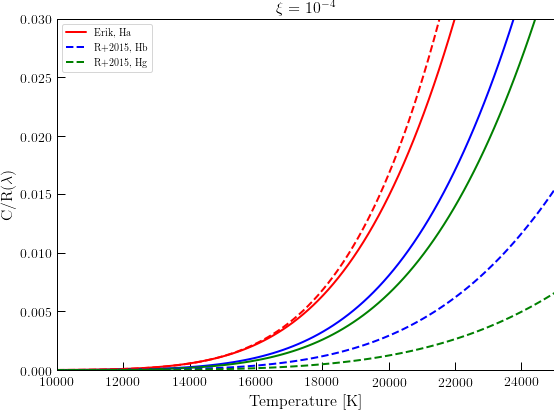

In [259]:
plt.subplots(figsize=(8,6))
plt.plot(test_temp, ha, color='red', label='Erik, Ha')
plt.plot(test_temp, hb, color='blue', label='__nolabel__')
plt.plot(test_temp, hg, color='green', label='__nolabel__')
plt.plot(test_temp, CR_R2015_Ha, color='red', ls='--', label='__nolabel__')
plt.plot(test_temp, CR_R2015_Hb, color='blue', ls='--', label='R+2015, Hb')
plt.plot(test_temp, CR_R2015_Hg, color='green', ls='--', label='R+2015, Hg')
plt.legend()
plt.xlabel('Temperature [K]')
plt.ylabel(r'C/R($\lambda$)')
plt.title(r'$\xi=10^{-4}$')
plt.ylim(0.0, 0.03)
plt.savefig('/Users/thsyu/Desktop/CR_dens1_xi1e-4.pdf')
plt.show()

In [163]:
HaEnergy = (const.h * (299792458.0*u.m/u.s/(6563.0*u.AA))).to(u.erg)
dens = 1.0
logdens = np.log10(dens)
alphak = S2018_ha_lin(test_temp, logdens).flatten() / HaEnergy.value
#CR = eta * q1k / alphak